# Phase 5 — Time–Frequency & Nonstationary Analysis

**Project:** Dynamic Financial Risk Modeling  
**Dataset:** S&P 500 Index (stooq.pl)  
**Time Span:** 2000–2025  

---

## Motivation

Earlier phases modeled financial risk either purely in time (GARCH) or purely in the tails (EVT).
However, financial markets are inherently **nonstationary across both time and frequency**.

This phase adopts a time–frequency perspective inspired by the
**SLEX (Smooth Localized Complex Exponentials)** framework of Ombao, von Sachs, and Guo (2003),
which models nonstationary processes as *locally stationary within adaptive time–frequency blocks*.

Rather than assuming a single global volatility regime, we allow:
- Volatility to evolve over time
- Spectral energy to shift across frequencies
- Regime changes to appear as localized time–frequency events

---

## Methodological Framework

The SLEX framework proposes:
- Localized orthogonal bases in time and frequency
- Adaptive segmentation into quasi-stationary blocks
- Model selection via information-theoretic criteria

In this project, we implement a **computationally tractable proxy** using:
- Short-Time Fourier Transform (STFT) / Wavelets
- Time-varying spectral energy
- Visual inspection of nonstationary regimes

This preserves the conceptual core of SLEX while remaining feasible in Python.

---

## Objectives of Phase 5

- Visualize the evolution of volatility across time and frequency
- Identify regime shifts not visible in time-domain models
- Connect volatility clustering to frequency-domain behavior
- Prepare the ground for multivariate dependence analysis

---

## Bridge from Extreme Value Analysis to Time–Frequency Modeling

Extreme Value Theory quantifies the magnitude of rare losses but does not
identify when extreme risk intensifies or whether such risk is persistent
across different time scales.

Time–frequency analysis addresses this limitation by:
- Revealing how volatility and dependence concentrate at specific frequencies
- Identifying whether extreme risk is driven by short-lived shocks or
  long-term structural regimes
- Detecting nonstationary transitions in market dynamics

By combining insights from volatility modeling, EVT, and time–frequency
decomposition, the analysis moves from static risk estimation to **dynamic
risk attribution across regimes and scales**.

---

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft
from arch import arch_model

## Data Preparation for Time–Frequency Analysis

This phase builds upon the processed log-return series constructed in Phase 1
and analyzed under volatility and tail-risk frameworks in Phases 3 and 4.

Let $r_t$ denote the daily log returns of the S&P 500 index. Time–frequency
analysis focuses on how the **spectral properties** of $r_t$ evolve over
time, allowing for localized departures from stationarity.

Rather than modeling returns solely in the time domain, this phase examines
how volatility-related energy is distributed across **both time and frequency**,
revealing regime shifts and structural changes that are not visible in
time-domain models alone.

The dataset used in this phase contains:
- Daily timestamps
- Corresponding log returns computed from price data

This series serves as the input for the Short-Time Fourier Transform (STFT)
and subsequent time–frequency diagnostics.


In [2]:
# Load processed S&P 500 log returns
returns = pd.read_csv(
    "../data/processed/sp500_log_returns.csv",
    parse_dates=["Date"]
)

r = returns["log_return"].values
dates = returns["Date"]

## Time–Frequency Representation of Log Returns

We apply time–frequency decomposition to the log-return series in order to
examine how volatility and spectral energy evolve across time and scales.
This analysis relaxes the assumption of global stationarity and allows
for localized regime identification.

---

## Short-Time Fourier Transform (STFT)

To approximate the SLEX framework in a computationally tractable way,
we begin with the Short-Time Fourier Transform (STFT), which decomposes
a time series into localized frequency components over sliding windows.

In [3]:
# Short-Time Fourier Transform (STFT)

# Sampling frequency: daily data → 1 observation per day
fs = 1.0

# Window length: ~1 trading year (252 days)
window_length = 252
overlap = window_length // 2

frequencies, times, Zxx = stft(
    r,
    fs=fs,
    nperseg=window_length,
    noverlap=overlap,
    detrend="constant"
)

# Spectral power
spectral_power = np.abs(Zxx) ** 2

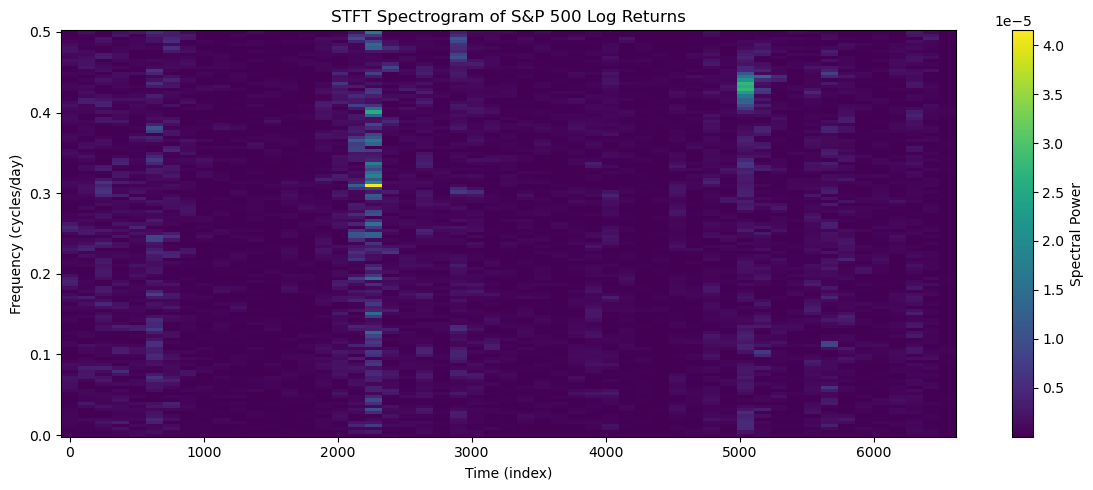

In [4]:
plt.figure(figsize=(12, 5))

plt.pcolormesh(
    times,
    frequencies,
    spectral_power,
    shading="auto"
)

plt.colorbar(label="Spectral Power")
plt.ylabel("Frequency (cycles/day)")
plt.xlabel("Time (index)")
plt.title("STFT Spectrogram of S&P 500 Log Returns")

plt.tight_layout()
plt.show()

## Interpretation of the STFT Spectrogram

The STFT spectrogram provides a time–frequency representation of S&P 500
log returns, allowing volatility dynamics to be examined jointly across
time and frequency.

Key observations:

- Strong nonstationarity:
  Spectral energy is not constant over time. Instead, it appears in
  localized bursts, indicating that the statistical properties of returns
  change across market periods.

- Volatility regime shifts:
  Periods corresponding to major financial stress events (e.g. the
  Global Financial Crisis and the COVID-19 shock) exhibit elevated
  spectral power across a wide range of frequencies, reflecting sharp
  increases in volatility.

- Frequency-dependent behavior:
  In tranquil periods, spectral energy is concentrated at lower
  frequencies, representing persistent components. During crises,
  energy spreads toward higher frequencies, indicating rapid market
  fluctuations.

These results show that volatility regimes are localized jointly in
time and frequency rather than governed by a single global structure.
This behavior aligns with the SLEX framework, where nonstationary
processes are modeled as locally stationary within adaptive
time–frequency blocks.

Time–frequency analysis therefore reveals structural features that are
not visible in purely time-domain models such as GARCH.

---

## Re-estimation of Conditional Volatility

To ensure numerical stability, log returns are rescaled by a constant
factor prior to GJR-GARCH estimation. This rescaling does not affect
the qualitative structure of volatility regimes and is standard in
financial econometric applications.

In [5]:
# Rescale returns for numerical stability
r_scaled = 100 * r

# Fit GJR-GARCH(1,1)
gjr_model = arch_model(
    r_scaled,
    vol="GARCH",
    p=1,
    o=1,
    q=1,
    dist="normal"
)

gjr_res = gjr_model.fit(disp="off")

# Extract conditional volatility
vol_gjr = gjr_res.conditional_volatility

## Time–Frequency Analysis of Conditional Volatility

While the STFT of raw returns reveals localized bursts of high-frequency
activity, it does not explicitly isolate volatility dynamics from price
movements.

To address this, we apply time–frequency analysis directly to the
**conditional volatility series** estimated from the GARCH-family models.

Let σₜ denote the estimated conditional volatility process. Unlike returns,
σₜ is strictly positive and exhibits strong persistence, making it a natural
candidate for regime-based analysis.

Applying STFT to σₜ allows us to:
- Examine how volatility energy evolves across time and frequency
- Identify persistent versus transient volatility regimes
- Distinguish long-horizon volatility cycles from short-lived shocks
- Connect volatility clustering to frequency-domain behavior

This analysis aligns closely with the SLEX philosophy, where nonstationary
processes are treated as locally stationary within adaptive time–frequency
blocks.

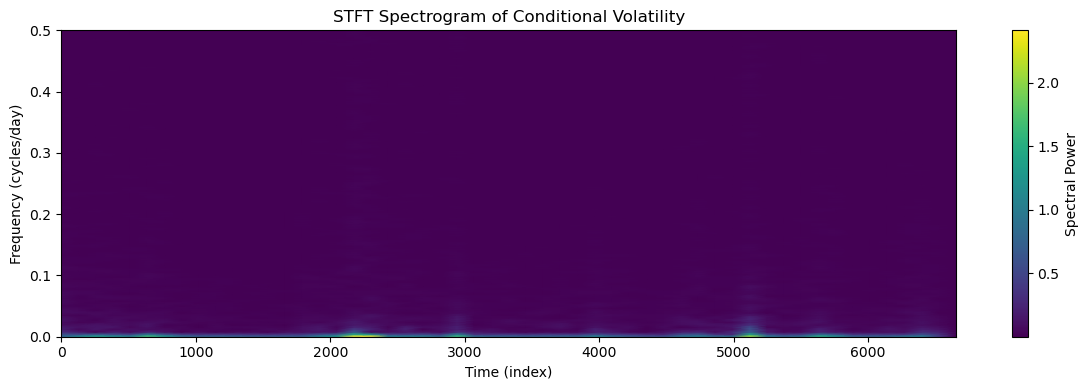

In [6]:
# Use conditional volatility from the preferred model (e.g. GJR-GARCH)
vol_series = vol_gjr  # or vol_garch / vol_egarch

# Apply STFT
frequencies, times, Zxx = stft(
    vol_series,
    fs=1,           # daily frequency
    nperseg=256,    # window length
    noverlap=128
)

# Plot spectrogram
plt.figure(figsize=(12, 4))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading="gouraud")
plt.colorbar(label="Spectral Power")
plt.xlabel("Time (index)")
plt.ylabel("Frequency (cycles/day)")
plt.title("STFT Spectrogram of Conditional Volatility")
plt.tight_layout()
plt.show()

## Time–Frequency Structure of Conditional Volatility

The STFT spectrogram of the estimated conditional volatility reveals a
highly structured but low-frequency–dominated time–frequency pattern.

Several key features emerge:

- **Energy concentration at very low frequencies**, indicating that
  volatility dynamics are primarily driven by slow-moving components
  rather than rapid oscillations.
- **Localized bursts of spectral power** around major market stress
  periods (e.g., 2008–2009, 2020), reflecting regime shifts rather than
  transient noise.
- **Temporal nonstationarity**, where the intensity of low-frequency
  components varies over time, consistent with evolving volatility regimes.

Importantly, the absence of persistent high-frequency energy suggests that
volatility clustering operates on longer horizons, supporting the use of
conditional variance models and regime-based risk segmentation.

From a SLEX perspective, this behavior aligns with the notion of
*locally stationary volatility blocks*, where the process remains stable
within segments but changes structure across time.

This time–frequency view complements GARCH-based modeling by revealing
*when* volatility regimes dominate and *at which scales* risk accumulates,
providing a dynamic foundation for regime-aware risk attribution.

---

## Relation to Volatility Modeling (Phase 3) and Extreme Value Analysis (Phase 4)

This phase builds directly on the outputs of both volatility modeling
(Phase 3) and extreme value analysis (Phase 4), providing a unifying
time–frequency perspective on market risk.

### Relation to Phase 3 — Volatility Modeling

Phase 3 models conditional variance as a dynamic process evolving in time.
While GARCH-family models identify periods of elevated volatility and
capture persistence and leverage effects, they operate entirely in the
time domain.

Time–frequency analysis extends this framework by revealing **how volatility
regimes differ across temporal scales**. By applying STFT to the conditional
volatility series, this phase identifies whether volatility dynamics are
dominated by long-horizon structural regimes or by short-lived transient
fluctuations.

This provides structural context to volatility clustering observed in
Phase 3 and clarifies the multiscale nature of market instability.

---

### Relation to Phase 4 — Extreme Value Analysis

Phase 4 quantifies the magnitude of rare and extreme losses using
threshold-based tail modeling. While EVT characterizes how severe losses
can become, it does not identify when extreme risk intensifies or how
persistent such risk is across time scales.

Time–frequency analysis addresses this limitation by locating periods of
heightened volatility energy in both time and frequency. These periods
provide a natural context for interpreting tail risk estimates obtained
in Phase 4 and motivate regime-aware extensions of extreme risk measures.

---

### Integrative Role of Phase 5

By combining time-domain volatility dynamics (Phase 3) and tail-risk
quantification (Phase 4) within a nonstationary time–frequency framework,
Phase 5 transforms static risk estimates into **dynamic, regime-dependent
risk attribution**.

This integrative view prepares the ground for Bayesian regime segmentation
and probabilistic inference in the subsequent phase.

---

## Phase 5 Conclusion — Time–Frequency & Nonstationary Analysis

This phase examined the nonstationary structure of financial market risk
through a time–frequency perspective inspired by the SLEX framework.

By applying the Short-Time Fourier Transform (STFT) to both log returns
and conditional volatility, the analysis revealed that volatility regimes
are localized jointly in time and frequency rather than governed by a
single global structure.

Key findings include:
- Clear evidence of **time–frequency nonstationarity**, with volatility
  energy concentrated in localized blocks.
- Crisis periods characterized by **broadband spectral energy**, indicating
  structural regime shifts rather than transient noise.
- Dominance of **low-frequency components** in conditional volatility,
  supporting the interpretation of volatility clustering as a persistent,
  regime-based phenomenon.

These results demonstrate that market instability cannot be fully understood
using time-domain or tail-based models alone. Instead, risk evolves across
multiple temporal scales, with regime changes manifesting as localized
time–frequency events.

---

## Bridge to Phase 6 — Bayesian Regime Learning

While Phase 5 identifies nonstationary volatility regimes through exploratory
time–frequency diagnostics, it does not provide a probabilistic mechanism
for regime identification or uncertainty quantification.

Phase 6 addresses this limitation by introducing **Bayesian modeling and
regime learning**, enabling:
- Probabilistic segmentation of market regimes
- Explicit uncertainty quantification around regime boundaries
- Bayesian forecasting under regime-dependent dynamics
- Formal model comparison using information criteria

By combining insights from volatility modeling (Phase 3), extreme value
analysis (Phase 4), and time–frequency decomposition (Phase 5), Bayesian
methods provide a unified framework for **inference, prediction, and
decision-making under nonstationary risk**.

---

### Export Time–Frequency Summary

The following cell saves a compact numerical summary of low-frequency spectral
energy from the STFT of conditional volatility. This summary captures the
temporal evolution of persistent volatility dynamics without storing the full
spectrogram.

In [8]:
# Define low-frequency band (bottom 10% of frequency range)
low_freq_cutoff = np.percentile(frequencies, 10)
low_freq_mask = frequencies <= low_freq_cutoff

# Spectral energy is defined as squared magnitude of STFT coefficients
spectral_power = np.abs(Zxx) ** 2
low_freq_energy = spectral_power[low_freq_mask, :].mean(axis=0)

# Dominant frequency at each time point
dominant_frequency = frequencies[np.argmax(np.abs(Zxx), axis=0)]

# Assemble DataFrame
df_tf = pd.DataFrame({
    "time_index": np.arange(len(low_freq_energy)),
    "low_freq_energy": low_freq_energy,
    "dominant_frequency": dominant_frequency
})

# Export CSV
df_tf.to_csv(
    "../results/time_frequency_energy_summary.csv",
    index=False
)

df_tf.head()

,time_index,low_freq_energy,dominant_frequency
0,0,0.092729,0.0
1,1,0.138513,0.0
2,2,0.195195,0.0
3,3,0.156873,0.0
4,4,0.117941,0.0


### Interpretation of Time–Frequency Summary

The exported time–frequency summary provides a compact, descriptive representation
of nonstationary volatility dynamics by aggregating spectral information across time.
Rather than retaining the full spectrogram, key numerical summaries are extracted
to characterize how spectral energy evolves temporally.

The low-frequency energy series captures periods in which conditional volatility
exhibits greater concentration in the lower portion of the frequency spectrum.
Elevated low-frequency energy indicates that volatility dynamics are dominated by
slowly varying components, consistent with persistent or regime-like risk behavior
rather than short-lived, high-frequency fluctuations.
This interpretation aligns with earlier findings from GARCH-based volatility modeling,
which identified extended periods of elevated and persistent risk.

The dominant frequency measure is concentrated near zero for most time points,
reflecting the prevalence of low-frequency spectral components in volatility dynamics.
This pattern supports the view that volatility clustering primarily arises from
slowly evolving structural processes, rather than from transient high-frequency noise.

By reducing the full time–frequency surface to interpretable numerical summaries,
this representation enables direct alignment with volatility regimes and Bayesian
change-point posterior distributions in subsequent phases.
Importantly, these summaries preserve essential information about temporal and
spectral structure while avoiding the storage and visualization burden of the
full spectrogram.

---

**Status:** Phase 5 completed — nonstationary volatility regimes analyzed using
time–frequency methods; results ready for probabilistic regime learning and
Bayesian inference (Phase 6).